# Dynamic Voxel Grids

The main idea of a dynamic voxel grid is a variability in voxel size which is proportional to the distance from the origin. The approach is motivated by a decrease in the certainty of a measurement with increasing distance from the origin. The propability of a measurement being in a neighboring and therefor incorrect gridcell increases. Thereby a reasonable idea seems to increase the size of a grid cell in proportion to the increase in inaccuracy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

We need to parameterize the creation of the voxel grid. As a baseline we take a constant increase for each voxel center by incremental addition. With a constant grid size, each grid cell center would have a fixed distance to the previous one. 

$\texttt{vcenter}_{i+1} = \texttt{vcenter}_i + \texttt{vsize}$

A distribution of voxel centers along one dimension could look something like this.

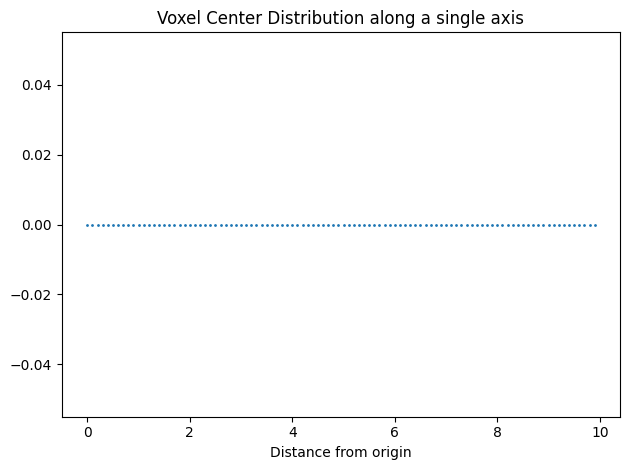

In [2]:
num_voxels = 100
plt.title('Voxel Center Distribution along a single axis')
plt.scatter(np.arange(num_voxels) * 0.1, np.zeros(num_voxels), s=1)
plt.xlabel('Distance from origin')
plt.tight_layout()

In order to accomodate for the increase in voxel center distances the baseline is now given an additional term that increases dependent on the distance of the voxel center from the origin.


$\texttt{vcenter}_{i+1} = \texttt{vcenter}_i + \texttt{vsize\_init} + \texttt{shift}(||\texttt{vcenter}_i||)$

The $\texttt{shift}(\cdot)$ function is a monotonous function parameterized by two factors:
1. When to start increasing?
2. How fast to increase?

Mathematically, the $\texttt{shift}(\cdot)$ function has to fullfil following properties:

1. $\forall x \in \mathbb{R} : \texttt{shift}(x) \rightarrow \mathbb{R}^+$
2. $\forall x_1, x_2 \in \mathbb{R} : x_1 \leq x_2 \Rightarrow \texttt{shift}(x_1) \leq \texttt{shift}(x_2)$

One widespread function, which fullfils both those properties and is therefor canonically applicabale to this use case is the [Rectified Linear Unit (ReLU) Function](https://arxiv.org/pdf/1803.08375)

Text(0, 0.5, 'y')

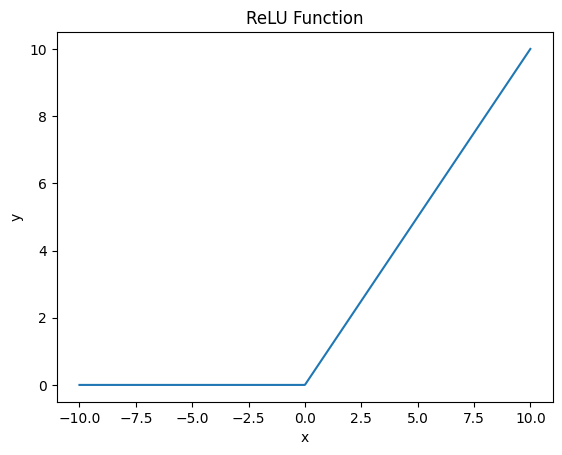

In [3]:
x = np.linspace(-10,10, 1000)
y = np.max([x, np.zeros_like(x)], axis=0)
plt.title('ReLU Function')
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')

We define a couple more function with non-linear increase, resulting in the following parameterization.

In [4]:
class VoxelCenterParameters:
    def __init__(self, parameters: dict = None):
        self._mode = "linear"
        self._resolution = 100
        self._initial_value = 0.1
        self._scaling = 1.0
        self._min_x = -50.0
        self._max_x = 50.0
        self._min_y = -50.0
        self._range_max_y = 50.0
        self._range_min_z = -1.0
        self._range_max_z = 3.0
        self._ndim = 3
        self._exp_scaling = 0.1
        if parameters is not None:
            self._mode = parameters.get("mode", self._mode)
            self._resolution = parameters.get("resolution", self._resolution)
            self._initial_value = parameters.get("initial_value", self._initial_value)
            self._scaling = parameters.get("scaling", self._scaling)

            self._ndim = len(parameters.get("range", range(6))) // 2
            default_range = [-50.0, -50.0, -1.0, 50.0, 50.0, 3.0]

            self._range_min_x = parameters.get("range", default_range)[0]
            self._range_max_x = parameters.get("range", default_range)[self._ndim]
            if self._ndim > 1:
                self._range_min_y = parameters.get("range", default_range)[1]
                self._range_max_y = parameters.get("range", default_range)[
                    self._ndim + 1
                ]
            if self._ndim > 2:
                self._range_min_z = parameters.get("range", default_range)[2]
                self._range_max_z = parameters.get("range", default_range)[
                    self._ndim + 2
                ]

    @property
    def mode(self):
        return self._mode

    @property
    def resolution(self):
        return self._resolution

    @property
    def initial_value(self):
        return self._initial_value

    @property
    def scaling(self):
        return self._scaling

    @property
    def min_x(self):
        return self._range_min_x

    @property
    def max_x(self):
        return self._range_max_x

    @property
    def min_y(self):
        return self._range_min_y

    @property
    def max_y(self):
        return self._range_max_y

    @property
    def min_z(self):
        return self._range_min_z

    @property
    def max_z(self):
        return self._range_max_z

    @property
    def ndim(self):
        return self._ndim

    @property
    def exp_scaling(self):
        return self._exp_scaling

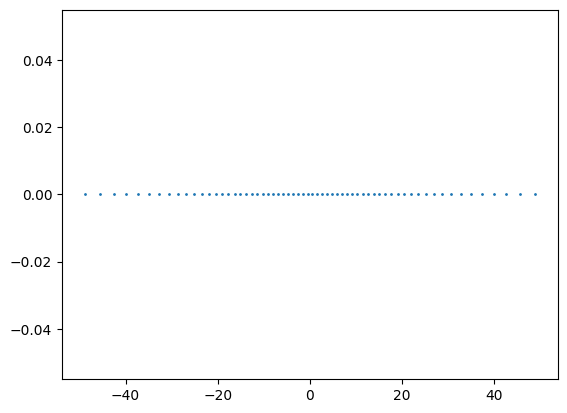

In [5]:
def calculate_voxel_centers_1d(parameters: VoxelCenterParameters):
    """
    Returns a vector with voxel centers given a parameterization.

            Parameters:
                    a (int): A decimal integer

            Returns:
                    binary_sum (str): Binary string of the sum of a and b
    """
    voxel_centers = np.linspace(
        parameters.min_x, parameters.max_x, parameters.resolution
    )
    normalization_constant = np.max(np.abs(voxel_centers))
    if parameters.mode == "linear":
        scaling_function = np.abs(voxel_centers) / normalization_constant
    elif parameters.mode == "exponential":
        scaling = 0.1
        scaling_function = np.exp(np.abs(voxel_centers) * scaling) / np.exp(
            normalization_constant * scaling
        )
    elif parameters.mode == "quadratic":
        scaling_function = np.abs(voxel_centers) ** 2 / normalization_constant**2
    else:
        raise NotImplementedError()
    voxel_centers *= np.ones_like(voxel_centers) + scaling_function * parameters.scaling
    voxel_centers = voxel_centers[voxel_centers < parameters.max_x]
    voxel_centers = voxel_centers[voxel_centers > parameters.min_x]
    return voxel_centers


parameters = VoxelCenterParameters(
    {
        "resolution": 100,
        "range": [-50, 50],
        "initial_value": 0.1,
        "scaling": 4.0,
        "mode": "exponential",
    }
)

voxel_centers = calculate_voxel_centers_1d(parameters)
delta = [voxel_centers[i + 1] - voxel_centers[i] for i in range(len(voxel_centers) - 1)]
delta.insert(0, 0)
# plt.figure(figsize=(15,15))

plt.scatter(voxel_centers, np.zeros_like(voxel_centers), s=1)

In [6]:
def calculate_voxel_centers(parameters: VoxelCenterParameters):
    n_dim = parameters.ndim
    if n_dim == 1:
        voxel_centers = np.linspace(
            parameters.min_x,
            parameters.max_x,
            parameters.resolution,
        ).reshape(1, -1)
    elif n_dim == 2:
        voxel_centers = np.stack(
            [
                f.flatten()
                for f in np.meshgrid(
                    np.linspace(
                        parameters.min_x,
                        parameters.max_x,
                        parameters.resolution,
                    ),
                    np.linspace(
                        parameters.min_y,
                        parameters.max_y,
                        parameters.resolution,
                    ),
                )
            ],
            axis=0,
        )
    elif n_dim == 3:
        voxel_centers = np.stack(
            [
                f.flatten()
                for f in np.meshgrid(
                    np.linspace(
                        parameters.min_x,
                        parameters.max_x,
                        parameters.resolution,
                    ),
                    np.linspace(
                        parameters.min_y,
                        parameters.max_y,
                        parameters.resolution,
                    ),
                    np.linspace(
                        parameters.min_z,
                        parameters.max_z,
                        parameters.resolution,
                    ),
                )
            ],
            axis=0,
        )
    else:
        raise NotImplementedError()

    voxel_norms = np.linalg.norm(voxel_centers, axis=0)
    normalization_constant = np.max(np.abs(voxel_norms))
    if parameters.mode == "linear":
        scaling_function = np.abs(voxel_norms) / normalization_constant
    elif parameters.mode == "exponential":
        exp_scaling = parameters.exp_scaling
        scaling_function = np.exp(np.abs(voxel_norms) * exp_scaling) / np.exp(
            normalization_constant * exp_scaling
        )
    elif parameters.mode == "quadratic":
        scaling_function = np.abs(voxel_norms) ** 2 / normalization_constant**2
    else:
        raise NotImplementedError()
    voxel_centers *= (
        np.ones_like(voxel_centers) + scaling_function * parameters.scaling
    )

    if n_dim == 1:
        voxel_centers = voxel_centers[
            :,
            np.logical_and(
                voxel_centers[0] > parameters.min_x,
                voxel_centers[0] < parameters.max_x,
            ),
        ]
    elif n_dim == 2:
        voxel_centers = voxel_centers[
            :,
            np.logical_and(
                np.logical_and(
                    voxel_centers[0] > parameters.min_x,
                    voxel_centers[0] < parameters.max_x,
                ),
                np.logical_and(
                    voxel_centers[1] > parameters.min_y,
                    voxel_centers[1] < parameters.max_y,
                ),
            ),
        ]
    elif n_dim == 3:
        voxel_centers = voxel_centers[
            :,
            np.logical_and(
                np.logical_and(
                    voxel_centers[0] > parameters.min_x,
                    voxel_centers[0] < parameters.max_x,
                ),
                np.logical_and(
                    voxel_centers[1] > parameters.min_y,
                    voxel_centers[1] < parameters.max_y,
                ),
                np.logical_and(
                    voxel_centers[2] > parameters.min_z,
                    voxel_centers[2] < parameters.max_z,
                ),
            ),
        ]
    return voxel_centers

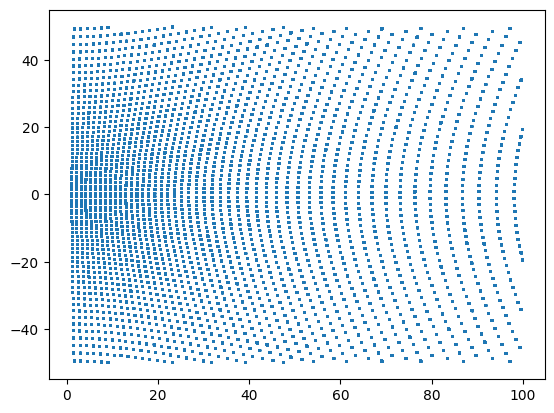

In [7]:
parameters = VoxelCenterParameters(
    {
        "resolution": 100,
        "range": [0, -50, 0.5, 100, 50, 2.5],
        "initial_value": 0.1,
        "scaling": 5.0,
        "mode": "quadratic",
    }
)

X, Y, Z = calculate_voxel_centers(parameters)
plt.scatter(X, Y, s=1)

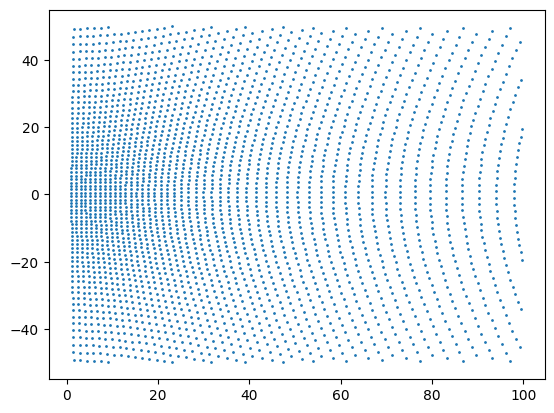

In [8]:
parameters = VoxelCenterParameters(
    {
        "resolution": 100,
        "range": [0, -50, 100, 50],
        "initial_value": 0.1,
        "scaling": 5.0,
        "mode": "quadratic",
    }
)

X, Y = calculate_voxel_centers(parameters)
plt.scatter(X, Y, s=1)

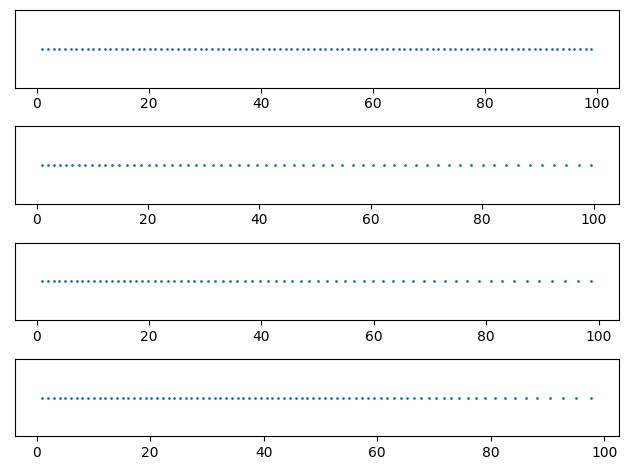

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=1)

parameters = VoxelCenterParameters(
    {
        "resolution": 100,
        "range": [0, 100],
        "initial_value": 0.1,
        "scaling": 0.0,
        "mode": "linear",
    }
)

X_none = calculate_voxel_centers(parameters)
axs[0].scatter(X_none, np.zeros_like(X_none), s=1)
axs[0].get_yaxis().set_visible(False)


parameters = VoxelCenterParameters(
    {
        "resolution": 100,
        "range": [0, 100],
        "initial_value": 0.1,
        "scaling": 1.0,
        "mode": "linear",
    }
)

X_lin = calculate_voxel_centers(parameters)
axs[1].scatter(X_lin, np.zeros_like(X_lin), s=1)
axs[1].get_yaxis().set_visible(False)

parameters = VoxelCenterParameters(
    {
        "resolution": 100,
        "range": [0, 100],
        "initial_value": 0.1,
        "scaling": 1.0,
        "mode": "quadratic",
    }
)

X_quad = calculate_voxel_centers(parameters)
axs[2].scatter(X_quad, np.zeros_like(X_quad), s=1)
axs[2].get_yaxis().set_visible(False)

parameters = VoxelCenterParameters(
    {
        "resolution": 100,
        "range": [0, 100],
        "initial_value": 0.1,
        "scaling": 1.0,
        "exp_scaling": 0.1,
        "mode": "exponential",
    }
)

X_exp = calculate_voxel_centers(parameters)
axs[3].scatter(X_exp, np.zeros_like(X_exp), s=1)
axs[3].get_yaxis().set_visible(False)
plt.tight_layout()

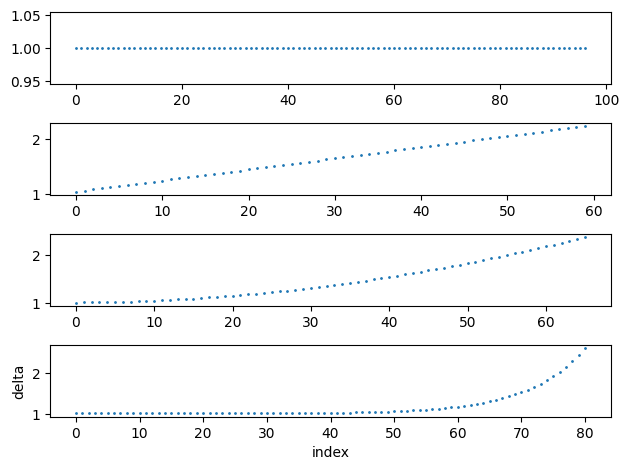

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=1)

X_none_delta = [
    int(X_none[0, i + 1] - X_none[0, i]) for i in range(X_none.shape[1] - 1)
]
axs[0].scatter(np.arange(len(X_none_delta)), X_none_delta, s=1)

X_lin_delta = [X_lin[0, i + 1] - X_lin[0, i] for i in range(X_lin.shape[1] - 1)]
axs[1].scatter(np.arange(len(X_lin_delta)), X_lin_delta, s=1)


X_quad_delta = [X_quad[0, i + 1] - X_quad[0, i] for i in range(X_quad.shape[1] - 1)]
axs[2].scatter(np.arange(len(X_quad_delta)), X_quad_delta, s=1)

X_exp_delta = [X_exp[0, i + 1] - X_exp[0, i] for i in range(X_exp.shape[1] - 1)]
axs[3].scatter(np.arange(len(X_exp_delta)), X_exp_delta, s=1)
axs[3].set_xlabel("index")
axs[3].set_ylabel("delta")

plt.tight_layout()

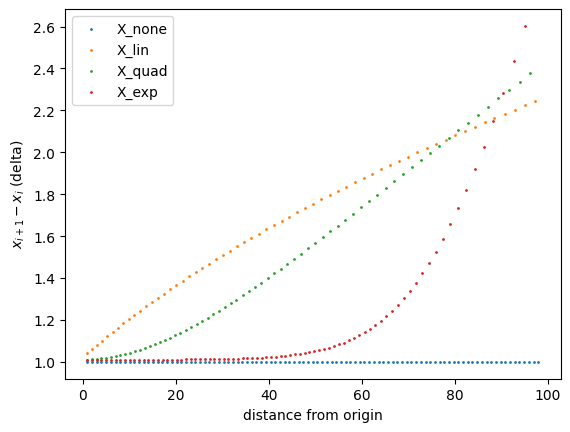

In [11]:
plt.scatter(X_none[0, :-1], X_none_delta, s=1)
plt.scatter(X_lin [0, :-1], X_lin_delta, s=1)
plt.scatter(X_quad[0, :-1], X_quad_delta, s=1)
plt.scatter(X_exp [0, :-1], X_exp_delta, s=1)
plt.xlabel("distance from origin")
plt.ylabel(r"$x_{i+1} - x_{i}$ (delta)")
plt.legend(
    [
        "X_none",
        "X_lin",
        "X_quad",
        "X_exp",
    ]
)

In [12]:
random_point = np.random.rand() * 100
ind = np.argmin(np.linalg.norm(X_exp - random_point, axis=0))
print("random_point =", random_point)
print("ind =", ind)
print("X_exp[0,ind] =", X_exp[0, ind])

random_point = 1.1085810783086458
ind = 0
X_exp[0,ind] = 1.0101517428173319


In [13]:
parameters = VoxelCenterParameters(
    {
        "resolution": 1000,
        "range": [-100, -100, 100, 100],
        "initial_value": 0.1,
        "scaling": 10.0,
        "mode": "exponential",
    }
)

X_quad = calculate_voxel_centers(parameters)
num_pts = 1000
rand_pts = np.random.randn(X_quad.shape[0], num_pts)
rand_pts[0] *= 20
rand_pts[0] += 50
rand_pts[1] *= 20
# rand_pts[2] *= 3

idx = [
    np.argmin(
        np.linalg.norm(
            X_quad
            - np.repeat(
                rand_pts[:, i].reshape(X_quad.shape[0], -1), X_quad.shape[1], axis=1
            ),
            axis=0,
        )
    )
    for i in range(num_pts)
    if rand_pts[0, i] > parameters.min_x
    and rand_pts[0, i] < parameters.max_x
    and rand_pts[1, i] > parameters.min_y
    and rand_pts[1, i] < parameters.max_y
]

/home/evgeny/miniconda3/envs/range-experts/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/evgeny/miniconda3/envs/range-experts/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


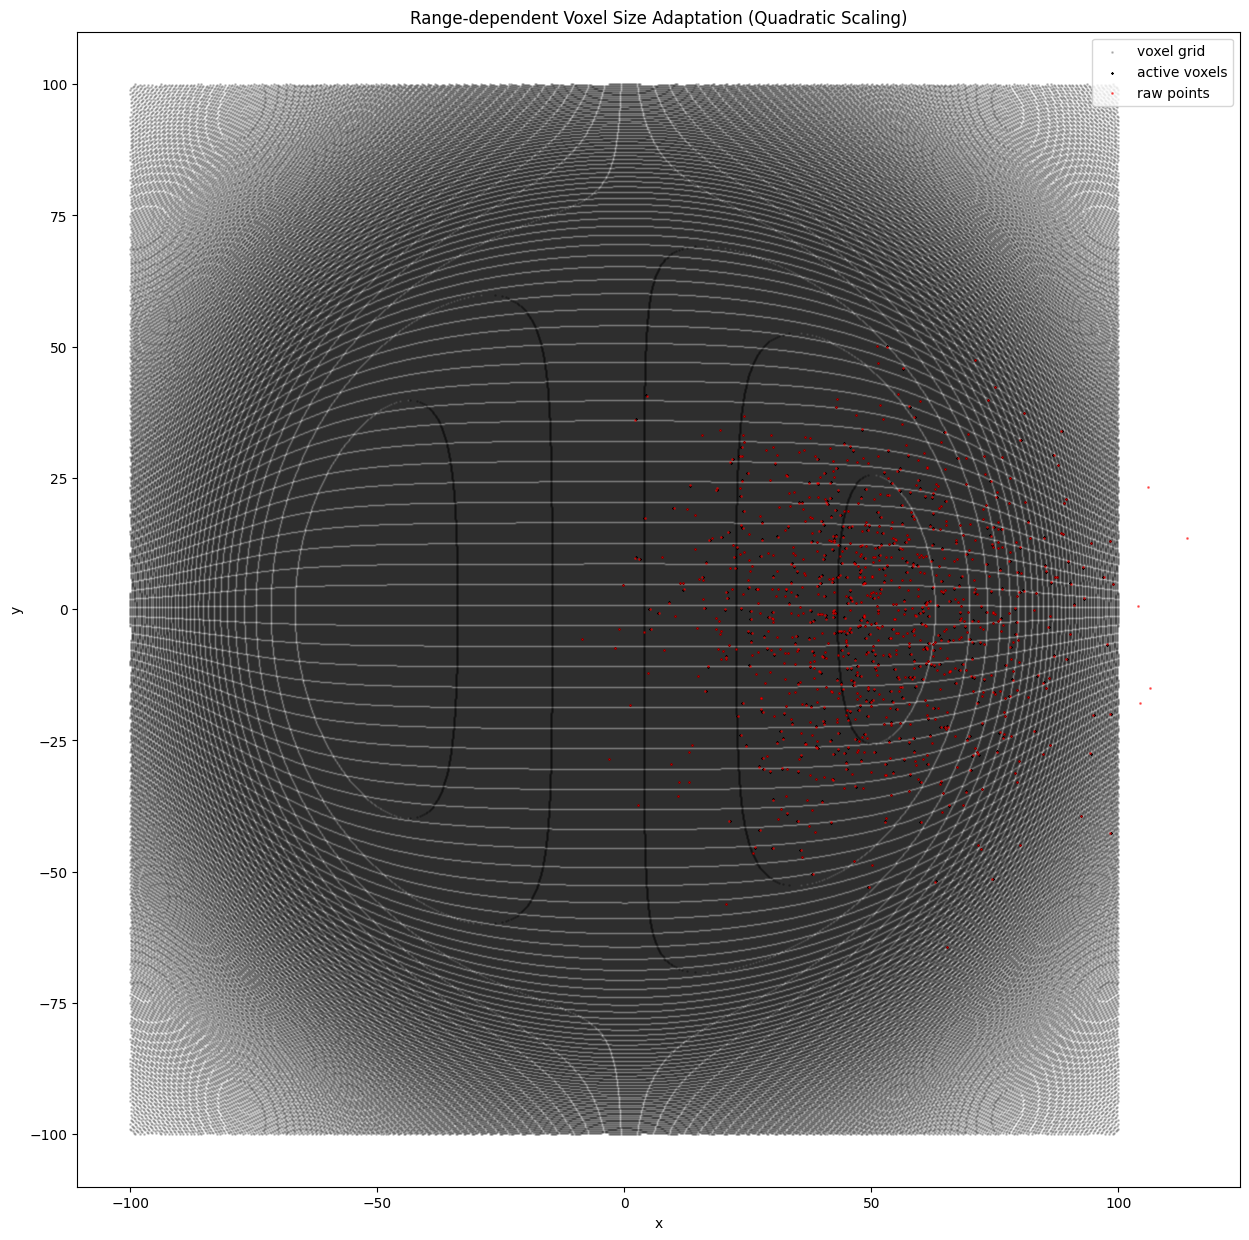

In [14]:
plt.figure(figsize=(15, 15))
plt.title("Range-dependent Voxel Size Adaptation (Quadratic Scaling)")
plt.scatter(X_quad[0], X_quad[1], s=1, c="k", alpha=0.2)
plt.scatter(X_quad[0, idx], X_quad[1, idx], marker="x", s=1, c="k")
plt.scatter(rand_pts[0], rand_pts[1], s=1, c="r", alpha=0.5, marker="o")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["voxel grid", "active voxels", "raw points"])

In [15]:
class Voxelizer:
    def __init__(self, parameters: VoxelCenterParameters):
        self.parameters = parameters
        self.voxel_grid = calculate_voxel_centers(parameters)
        self.n_dim = parameters.ndim

    def __call__(self, pts: np.ndarray):
        pts_ndim, num_pts = pts.shape
        assert pts_ndim >= self.n_dim
        if self.n_dim == 1:
            in_range = np.logical_and(
                pts[0] > self.parameters.min_x,
                pts[0] < self.parameters.max_x,
            )
        elif self.n_dim == 2:
            in_range = np.logical_and(
                np.logical_and(
                    pts[0] > self.parameters.min_x,
                    pts[0] < self.parameters.max_x,
                ),
                np.logical_and(
                    pts[1] > self.parameters.min_y,
                    pts[1] < self.parameters.max_y,
                ),
            )
        elif self.n_dim == 3:
            in_range = np.logical_and(
                np.logical_and(
                    pts[0] > self.parameters.min_x,
                    pts[0] < self.parameters.max_x,
                ),
                np.logical_and(
                    pts[1] > self.parameters.min_y,
                    pts[1] < self.parameters.max_y,
                ),
                np.logical_and(
                    pts[2] > self.parameters.min_z,
                    pts[2] < self.parameters.max_z,
                ),
            )
        idx = [
            np.argmin(
                np.linalg.norm(
                    self.voxel_grid
                    - np.repeat(
                        pts[: self.n_dim, i].reshape(self.voxel_grid.shape[0], -1),
                        self.voxel_grid.shape[1],
                        axis=1,
                    ),
                    axis=0,
                )
            )
            for i in range(num_pts)
            if in_range[i]
        ]
        return self.voxel_grid[:, idx]

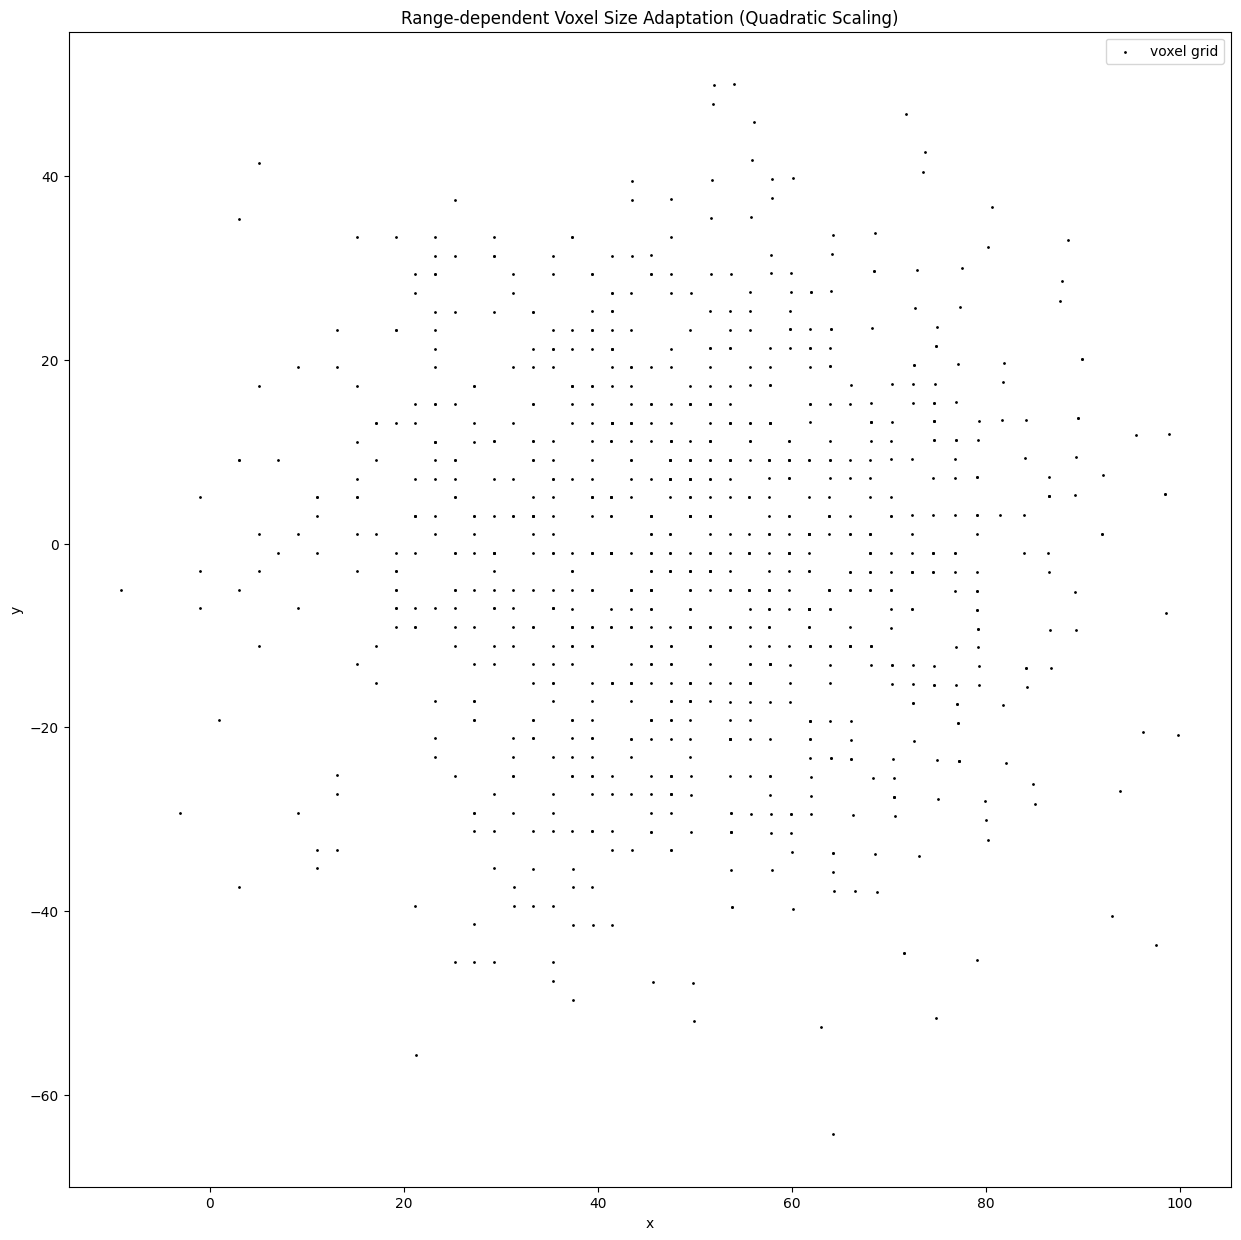

In [16]:
voxelizer = Voxelizer(
    VoxelCenterParameters(
        {
            "resolution": 100,
            "range": [-100, -100, 100, 100],
            "initial_value": 0.1,
            "scaling": 10.0,
            "mode": "exponential",
        }
    )
)
voxels = voxelizer(rand_pts)

plt.figure(figsize=(15, 15))
plt.title("Range-dependent Voxel Size Adaptation (Quadratic Scaling)")
plt.scatter(voxels[0], voxels[1], s=1, c="k")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["voxel grid", "active voxels", "raw points"])

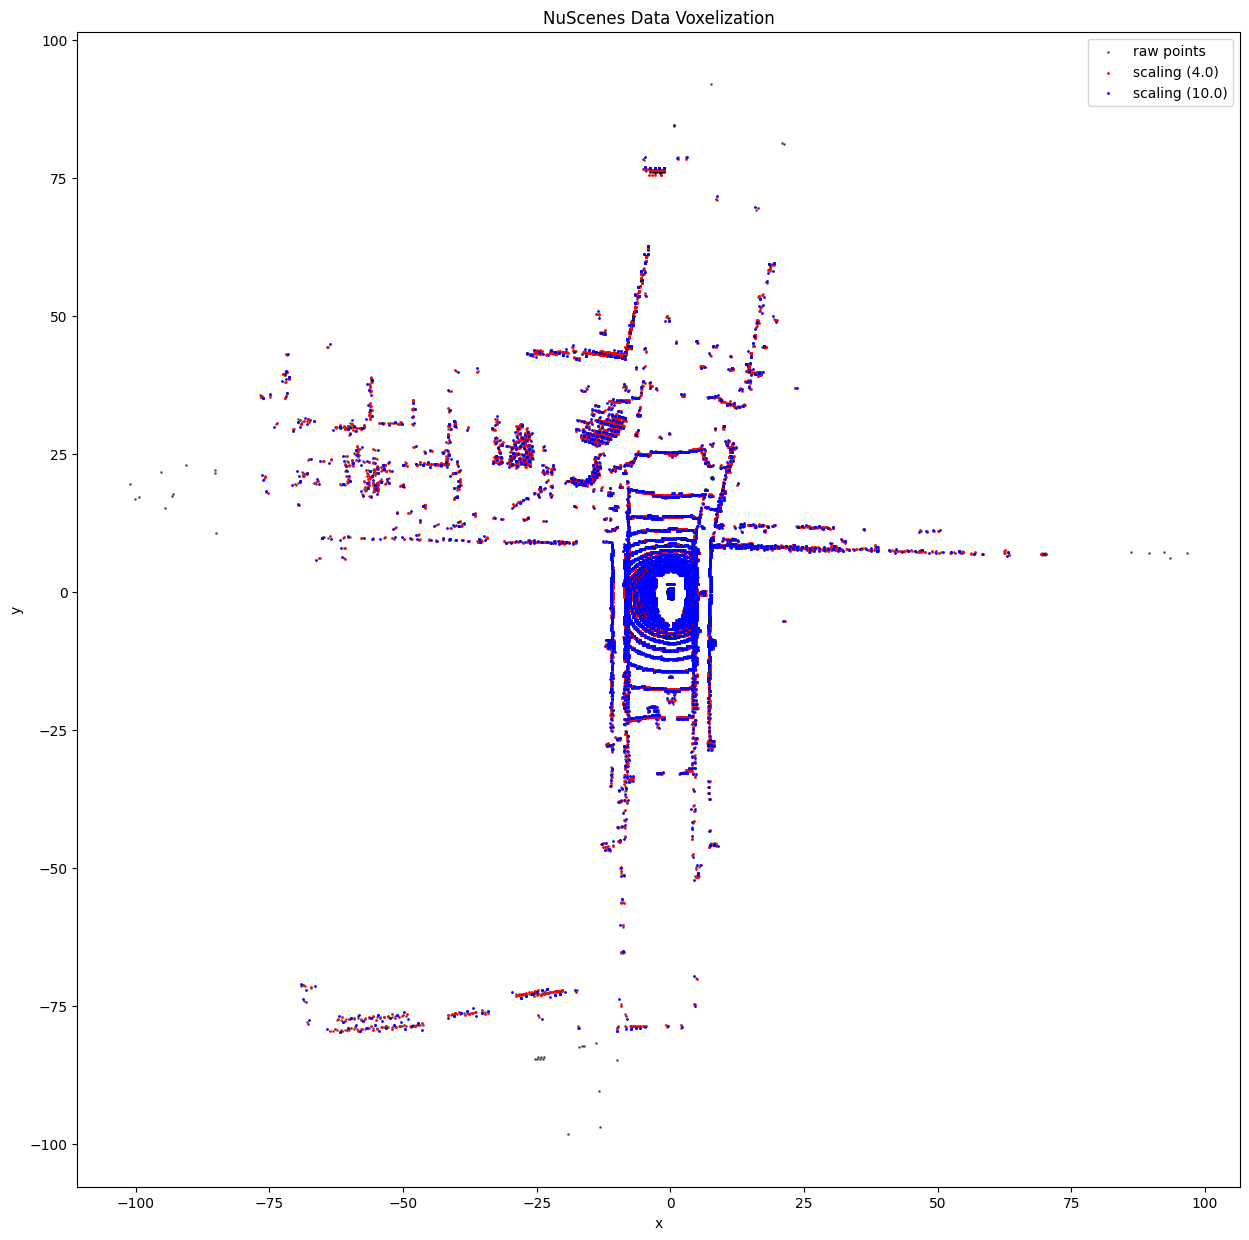

In [17]:
pcd = np.fromfile("data/nuscenes_datasample.bin", dtype=np.float32).reshape(-1, 5).T

plt.figure(figsize=(15, 15))
plt.scatter(pcd[0], pcd[1], s=1, c="k", alpha=0.5)
plt.title("NuScenes Data Voxelization")


voxelizer = Voxelizer(
    VoxelCenterParameters(
        {
            "resolution": 500,
            "range": [-80, -80, 80, 80],
            "initial_value": 0.1,
            "scaling": 4.0,
            "mode": "quadratic",
        }
    )
)
voxels = voxelizer(pcd[:2])

plt.scatter(voxels[0], voxels[1], s=1, c="r")

voxelizer = Voxelizer(
    VoxelCenterParameters(
        {
            "resolution": 500,
            "range": [-80, -80, 80, 80],
            "initial_value": 0.1,
            "scaling": 25.0,
            "mode": "quadratic",
        }
    )
)
voxels = voxelizer(pcd[:2])

plt.scatter(voxels[0], voxels[1], s=1, c="b")

plt.xlabel("x")
plt.ylabel("y")
plt.legend(["raw points", "scaling (4.0)", "scaling (10.0)"])

## Implementation of DynamicScatter

The ops operation [DynamicScatter](https://mmcv.readthedocs.io/en/2.x/api/generated/mmcv.ops.DynamicScatter.html) can be used.

In [18]:
from mmcv.ops import DynamicScatter
import torch

ds = DynamicScatter([0.1, 0.1, 0.1], [-50, -50, -1, 50, 50, 3], True)
coors = (
    torch.stack(
        torch.meshgrid(
            [
                torch.linspace(-50, 50, 1000),
                torch.linspace(-50, 50, 1000),
                torch.linspace(-1, 3, 400),
            ]
        )
    )
    .reshape(3, -1)
    .T
).to("cuda")
output = ds(torch.rand(10000, 4, device="cuda") * 20, coors)

/home/evgeny/miniconda3/envs/range-experts/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
from mmdet3d.models.voxel_encoders import DynamicSimpleVFE, DynamicVFE

ds_vfe = DynamicSimpleVFE()
output = ds_vfe(torch.rand(10000, 3, device="cuda"), coors)

In [20]:
def calculate_voxel_centers(parameters: dict):
    n_dim = 3
    point_cloud_range = [
        # min_x, min_y, min_z, max_x, max_y, max_z
        parameters["point_cloud_range"][0],
        parameters["point_cloud_range"][1],
        parameters["point_cloud_range"][2],
        parameters["point_cloud_range"][3],
        parameters["point_cloud_range"][4],
        parameters["point_cloud_range"][5],
    ]
    voxel_centers = torch.stack(
        [
            f.flatten()
            for f in torch.meshgrid(
                [
                    torch.linspace(
                        point_cloud_range[i],
                        point_cloud_range[i + n_dim],
                        parameters['resolution'],
                    )
                    for i in range(n_dim)
                ]
            )
        ],
        axis=0,
    )

    voxel_norms = torch.norm(voxel_centers, dim=0)
    normalization_constant = torch.max(torch.abs(voxel_norms))
    if parameters["mode"] == "linear":
        scaling_function = torch.abs(voxel_norms) / normalization_constant
    elif parameters["mode"] == "exponential":
        exp_scaling = parameters["exp_scaling"]
        scaling_function = torch.exp(torch.abs(voxel_norms) * exp_scaling) / np.exp(
            normalization_constant * exp_scaling
        )
    elif parameters["mode"] == "quadratic":
        scaling_function = torch.abs(voxel_norms) ** 2 / normalization_constant**2
    else:
        raise NotImplementedError()
    voxel_centers *= (
        torch.ones_like(voxel_centers) + scaling_function * parameters['scaling']
    )

    voxel_centers = voxel_centers[
        :,
        (voxel_centers[0] >= point_cloud_range[0])
        & (voxel_centers[0] <= point_cloud_range[3])
        & (voxel_centers[1] >= point_cloud_range[1])
        & (voxel_centers[1] <= point_cloud_range[4])
        & (voxel_centers[2] >= point_cloud_range[2])
        & (voxel_centers[2] <= point_cloud_range[5]),
    ]
    return voxel_centers


voxels_torch = calculate_voxel_centers(
    {
        "resolution": 500,
        "point_cloud_range": [-100, -100, -1, 100, 100, 3],
        "initial_value": 0.1,
        "scaling": 25.0,
        "mode": "quadratic",
    }
)

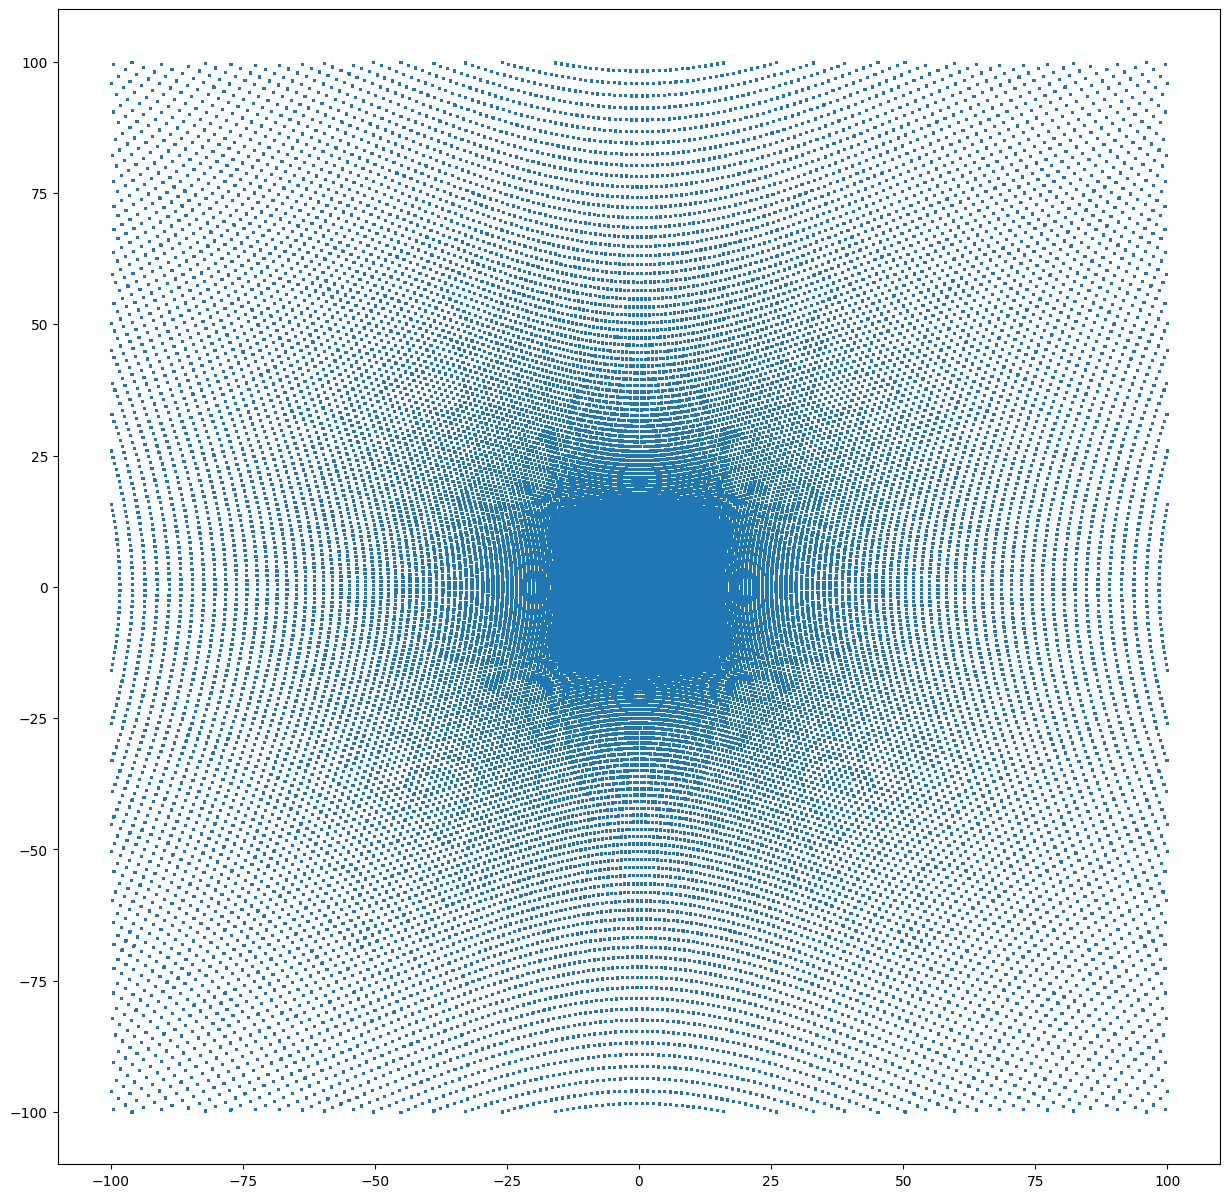

In [21]:
plt.figure(figsize=(15,15))
plt.scatter(voxels_torch[0], voxels_torch[1], s=1)

For the formula 

$x + sign(x) * scaling * x^2$

we can calculate a closed form solution.

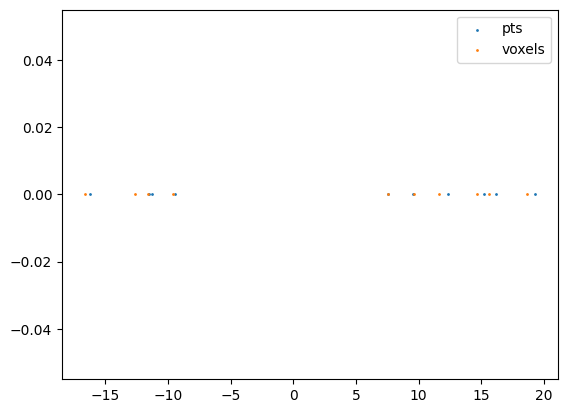

In [22]:
x_min = -51
x_max = 50
resolution = 100
scaling =  0.1

d = torch.linspace(x_min, x_max, int(resolution) + 1)
    
def calc_grid(x: torch.Tensor, x_min: float, x_max: float, scaling: float):
    x = x + torch.sign(x) * scaling * x**2
    x = x[(x > x_min) & (x < x_max)]
    return x

def calc_index(x: torch.Tensor, x_min: float, x_max: float, scaling: float):
    a = torch.sign(x) * scaling
    b = 1
    c = -x
    x_1 = (-b + torch.sqrt(b**2 - 4*a*c))/(2*a)
    grid_cell = calc_grid(x_1, x_min, x_max, scaling)
    ind = ((grid_cell.round() - x_min) / (x_max - x_min)  * resolution).tolist()
    return ind

pts = (torch.rand(10)-0.5)*50
plt.scatter(pts, torch.zeros_like(pts), s=1, label='pts')
plt.scatter(d[calc_index(pts, x_min, x_max, scaling)], torch.zeros_like(pts), s=1, label='voxels')
plt.legend()

In [23]:
x_min = -50
x_max = 50
y_min = -50
y_max = 50

d = torch.stack([f.flatten() for f in torch.meshgrid(torch.linspace(x_min, x_max, int(resolution) + 1),torch.linspace(y_min, y_max, int(resolution) + 1))])

In [24]:
def apply_adaptive_grid_2d(
    pts: torch.Tensor,
    x_min: float,
    x_max: float,
    y_min: float,
    y_max: float,
    scaling: float,
):
    pts = pts * (1 + scaling * pts.norm(dim=0) ** 2) 
    pts = pts[:,(pts[0] > x_min) & (pts[0] < x_max) & (pts[1] > y_min) & (pts[1] < y_max)]
    return pts

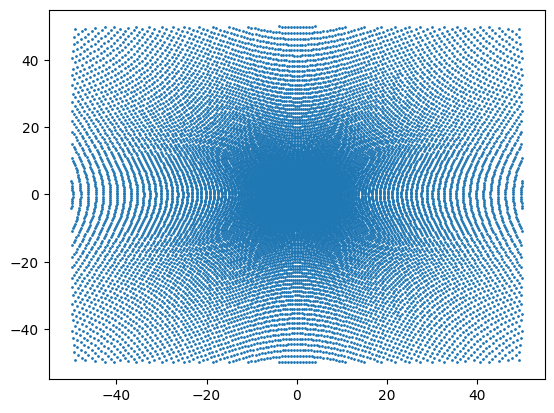

In [25]:
resolution = 1000
pts = torch.stack(
    [
        f.flatten()
        for f in torch.meshgrid(
            torch.linspace(x_min, x_max, int(resolution) + 1),
            torch.linspace(y_min, y_max, int(resolution) + 1),
        )
    ]
)
pts = pts * (1 + scaling * pts.norm(dim=0) ** 2)
points_in_range = torch.arange(pts.shape[1])[
    (pts[0] > x_min) & (pts[0] < x_max) & (pts[1] > y_min) & (pts[1] < y_max)
]
pts = pts[:, points_in_range]
plt.scatter(pts[0], pts[1], s=1)

We have to use an alternative kernel implementation for instead of DynamicScatter since DynamicScatter assumes a fixed grid. Our goal is to calculate the voxel index of a point by first calculating its representation in the adaptive grid. If we know the representation in the adaptive grid we can find the according coordinate in the fixed grid and thereafter calculate the voxel position for this index.

In [26]:
scaling = 0.1


def f(x: torch.Tensor, v: torch.Tensor):
    return (x + scaling * x.norm() * x - v) ** 2


def df(x: torch.Tensor, v: torch.Tensor):
    return (
        2
        * (scaling * (x.norm() ** 2 + x) / x.norm() + x.norm() + 1)
        * (scaling * x * x.norm() - v + x)
    )


v = torch.rand(3) * 3
x = torch.ones_like(v)
gamma = 0.1
grad = df(x, v)

print("f(x_init, v)=", f(x, v))

for i in range(20):
    x_n = x - gamma * grad
    grad_n = df(x_n, v)
    # used stepsize formulation from https://en.wikipedia.org/w/index.php?title=Gradient_descent&oldid=1230511110
    gamma = ((x_n - x) @ (grad_n - grad)).abs() / (grad_n - grad).norm() ** 2
    grad = grad_n
    x = x_n
    if f(x, v).norm() < 1e-3:
        break

print("f(x_end, v)=", f(x, v))
print("function value: ", x + scaling * x.norm() * x)
print("actual value: ", v)
print("iteration=", i)

f(x_init, v)= tensor([0.3015, 0.0192, 0.1887])
f(x_end, v)= tensor([5.5514e-04, 1.3392e-05, 4.0251e-04])
function value:  tensor([1.7459, 1.0384, 1.6276])
actual value:  tensor([1.7223, 1.0348, 1.6076])
iteration= 1


In [27]:
def get_x(v, scaling):
    f = lambda x: (x + scaling * x.norm() * x - v) ** 2

    df = (
        lambda x: 2
        * (scaling * (x.norm() ** 2 + x) / x.norm() + x.norm() + 1)
        * (scaling * x * x.norm() - v + x)
    )

    x = torch.ones_like(v)
    gamma = 0.1
    grad = df(x)

    for i in range(20):
        x_n = x - gamma * grad
        grad_n = df(x_n)
        gamma = ((x_n - x) @ (grad_n - grad)).abs() / (grad_n - grad).norm() ** 2
        grad = grad_n
        x = x_n
        if f(x).norm() < 1e-3:
            break
    return x

In [28]:
grid_min = torch.tensor([0, -100, -1])
grid_max = torch.tensor([200, 100, 3])
grid_res = torch.tensor([1000, 1000, 100])
scaling = 0.3

pts = torch.stack(
    [
        f.flatten()
        for f in torch.meshgrid(
            [
                torch.linspace(dim_min, dim_max, int(dim_res))
                for dim_min, dim_max, dim_res in zip(grid_min, grid_max, grid_res)
            ]
        )
    ]
)
pts_adaptive = pts * (1 + scaling * pts.norm(dim=0))

In [29]:
v = (torch.rand(3)) * (grid_max - grid_min) + grid_min
print("v = ", v)

x = get_x(v, scaling)
print("x = ", x)

idx = ((v - grid_min) / (grid_max - grid_min) * grid_res).round().type(torch.int)
print(
    "voxel = ",
    pts[:, idx[2] + idx[1] * grid_res[2] + idx[0] * grid_res[2] * grid_res[1]],
)

idx = ((x - grid_min) / (grid_max - grid_min) * grid_res).round().type(torch.int)
print(
    "adaptive voxel = ",
    pts_adaptive[:, idx[2] + idx[1] * grid_res[2] + idx[0] * grid_res[2] * grid_res[1]],
)

v =  tensor([141.8034, -30.1136,  -0.5482])
x =  tensor([19.9342, -4.2353, -0.0771])
voxel =  tensor([141.9419, -30.1301,  -0.5556])
adaptive voxel =  tensor([142.7617, -29.2661,  -0.5042])


In [30]:
points_in_range = torch.arange(pts_adaptive.shape[1])[
    (pts_adaptive[0] > grid_min[0])
    & (pts_adaptive[0] < grid_max[0])
    & (pts_adaptive[1] > grid_min[1])
    & (pts_adaptive[1] < grid_max[1])
    & (pts_adaptive[2] > grid_min[2])
    & (pts_adaptive[2] < grid_max[2])
]
pts_adaptive_filtered = pts_adaptive[:, points_in_range]
print(
    "filtered_point = ",
    pts_adaptive_filtered[
        :,
        (
            points_in_range
            == idx[2] + idx[1] * grid_res[2] + idx[0] * grid_res[2] * grid_res[1]
        ).nonzero()[0, 0],
    ],
)

filtered_point =  tensor([142.7617, -29.2661,  -0.5042])


In [31]:
grid_min = torch.tensor([0, -100])
grid_max = torch.tensor([200, 100])
grid_res = torch.tensor([100, 100])
scaling = 0.005

pts = torch.stack(
    [
        f.flatten()
        for f in torch.meshgrid(
            [
                torch.linspace(dim_min, dim_max, int(dim_res))
                for dim_min, dim_max, dim_res in zip(grid_min, grid_max, grid_res)
            ]
        )
    ]
)
pts_adaptive = pts * (1 + scaling * pts.norm(dim=0))
points_in_range = torch.arange(pts_adaptive.shape[1])[
    (pts_adaptive[0] > grid_min[0])
    & (pts_adaptive[0] < grid_max[0])
    & (pts_adaptive[1] > grid_min[1])
    & (pts_adaptive[1] < grid_max[1])
]
pts_adaptive_filtered = pts_adaptive[:, points_in_range]


v = (torch.rand(2)) * (grid_max - grid_min) + grid_min
print("v = ", v)

x = get_x(v, scaling)
idx = ((v - grid_min) / (grid_max - grid_min) * (grid_res - 1)).round().type(torch.int)
print("voxel = ", pts[:, idx[1] + idx[0] * grid_res[1]])

idx = ((x - grid_min) / (grid_max - grid_min) * (grid_res - 1)).round().type(torch.int)
print("adaptive voxel = ", pts_adaptive[:, idx[1] + idx[0] * grid_res[1]])

print(
    "adaptive_filtered_voxel = ",
    pts_adaptive_filtered[
        :,
        (points_in_range == idx[1] + idx[0] * grid_res[1]).nonzero()[0, 0],
    ],
)

v =  tensor([156.9174,  44.5704])
voxel =  tensor([157.5758,  45.4545])
adaptive voxel =  tensor([158.2100,  44.9813])
adaptive_filtered_voxel =  tensor([158.2100,  44.9813])


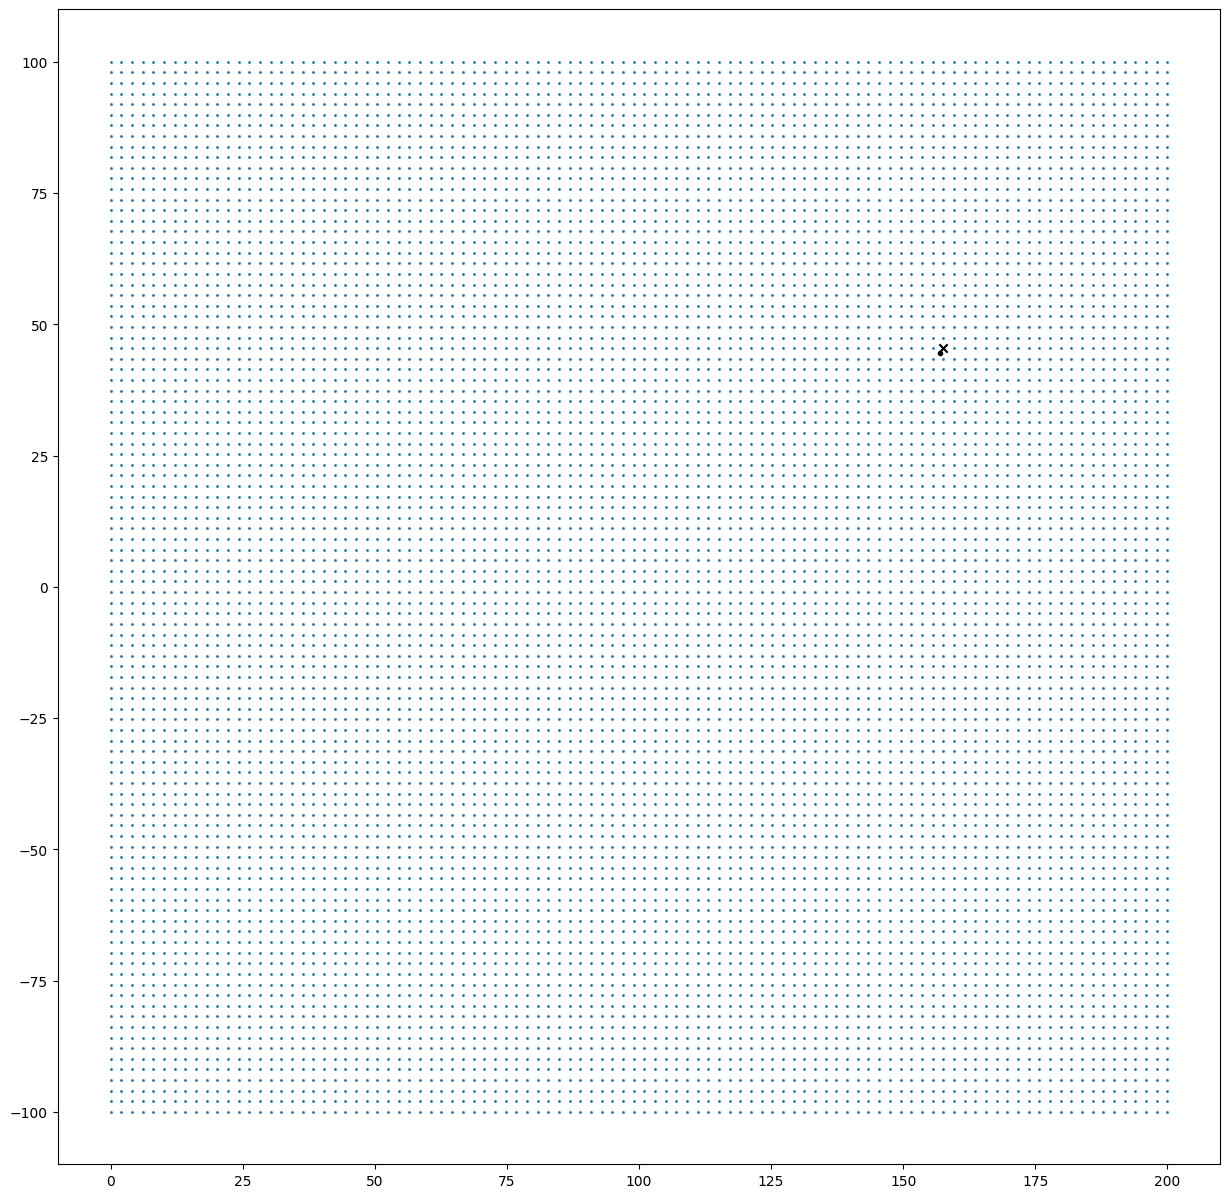

In [32]:
idx = ((v - grid_min) / (grid_max - grid_min) * (grid_res - 1)).round().type(torch.int)
voxel = pts[:, idx[1] + idx[0] * grid_res[1]]
plt.figure(figsize=(15, 15))
plt.scatter(pts[0], pts[1], s=1)
plt.scatter(v[0], v[1], marker=".", c="k")
plt.scatter(voxel[0], voxel[1], marker="x", c="k")

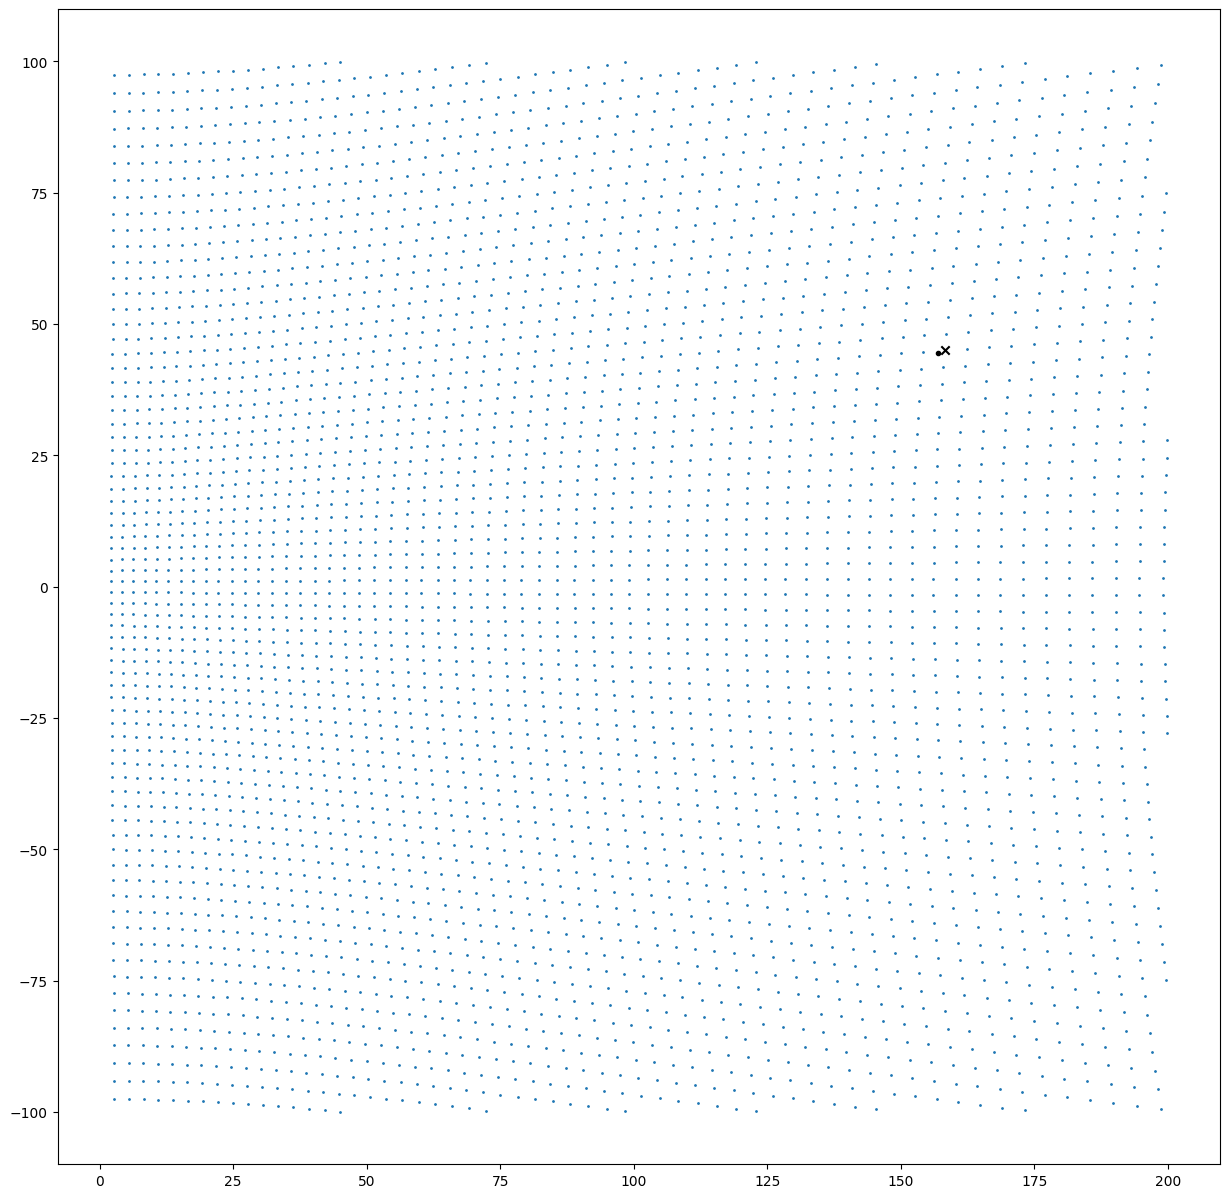

In [33]:
idx = ((x - grid_min) / (grid_max - grid_min) * (grid_res - 1)).round().type(torch.int)
adaptive_filtered_voxel = pts_adaptive_filtered[
    :, (points_in_range == idx[1] + idx[0] * grid_res[1]).nonzero()[0, 0]
]

plt.figure(figsize=(15, 15))
plt.scatter(pts_adaptive_filtered[0], pts_adaptive_filtered[1], s=1)
plt.scatter(v[0], v[1], marker=".", c="k")
plt.scatter(adaptive_filtered_voxel[0], adaptive_filtered_voxel[1], marker="x", c="k")

In [34]:
class AdaptiveVoxelizer(nn.Module):
    def __init__(self, params):
        super(AdaptiveVoxelizer, self).__init__()
        assert "point_cloud_range" in params
        assert "resolution" in params
        assert "scaling" in params

        self.grid_min = torch.tensor(
            [
                params["point_cloud_range"][0],
                params["point_cloud_range"][1],
                params["point_cloud_range"][2],
            ]
        )
        self.grid_max = torch.tensor(
            [
                params["point_cloud_range"][3],
                params["point_cloud_range"][4],
                params["point_cloud_range"][5],
            ]
        )
        self.grid_res = torch.tensor(
            [
                params["resolution"][0],
                params["resolution"][1],
                params["resolution"][2],
            ]
        )
        self.scaling = params["scaling"]

        pts = torch.stack(
            [
                f.flatten()
                for f in torch.meshgrid(
                    [
                        torch.linspace(dim_min, dim_max, int(dim_res))
                        for dim_min, dim_max, dim_res in zip(
                            self.grid_min, self.grid_max, self.grid_res
                        )
                    ]
                )
            ]
        )
        pts_adaptive = pts * (1 + self.scaling * pts.norm(dim=0))
        self.points_in_range = torch.arange(pts_adaptive.shape[1])[
            (pts_adaptive[0] > self.grid_min[0])
            & (pts_adaptive[0] < self.grid_max[0])
            & (pts_adaptive[1] > self.grid_min[1])
            & (pts_adaptive[1] < self.grid_max[1])
            & (pts_adaptive[2] > self.grid_min[2])
            & (pts_adaptive[2] < self.grid_max[2])
        ]
        self.pts_adaptive_filtered = pts_adaptive[:, self.points_in_range]

    def forward(self, points: torch.Tensor):
        points_filtered = points[
            :,
            (points[0] > self.grid_min[0])
            & (points[0] < self.grid_max[0])
            & (points[1] > self.grid_min[1])
            & (points[1] < self.grid_max[1])
            & (points[2] > self.grid_min[2])
            & (points[2] < self.grid_max[2]),
        ]
        voxels = torch.zeros_like(points_filtered)
        for i in range(points_filtered.shape[1]):
            idx = (
                (
                    (get_x(points_filtered[:, i], self.scaling) - self.grid_min)
                    / (self.grid_max - self.grid_min)
                    * (self.grid_res - 1)
                )
                .round()
                .type(torch.int)
            )
            idx_adaptive = (
                self.points_in_range
                == idx[2]
                + idx[1] * self.grid_res[2]
                + idx[0] * self.grid_res[2] * self.grid_res[1]
            ).nonzero()
            if len(idx_adaptive) == 0:
                continue
            voxels[:, i] = self.pts_adaptive_filtered[:, idx_adaptive[0, 0]]
        return voxels

    def backward(self):
        pass

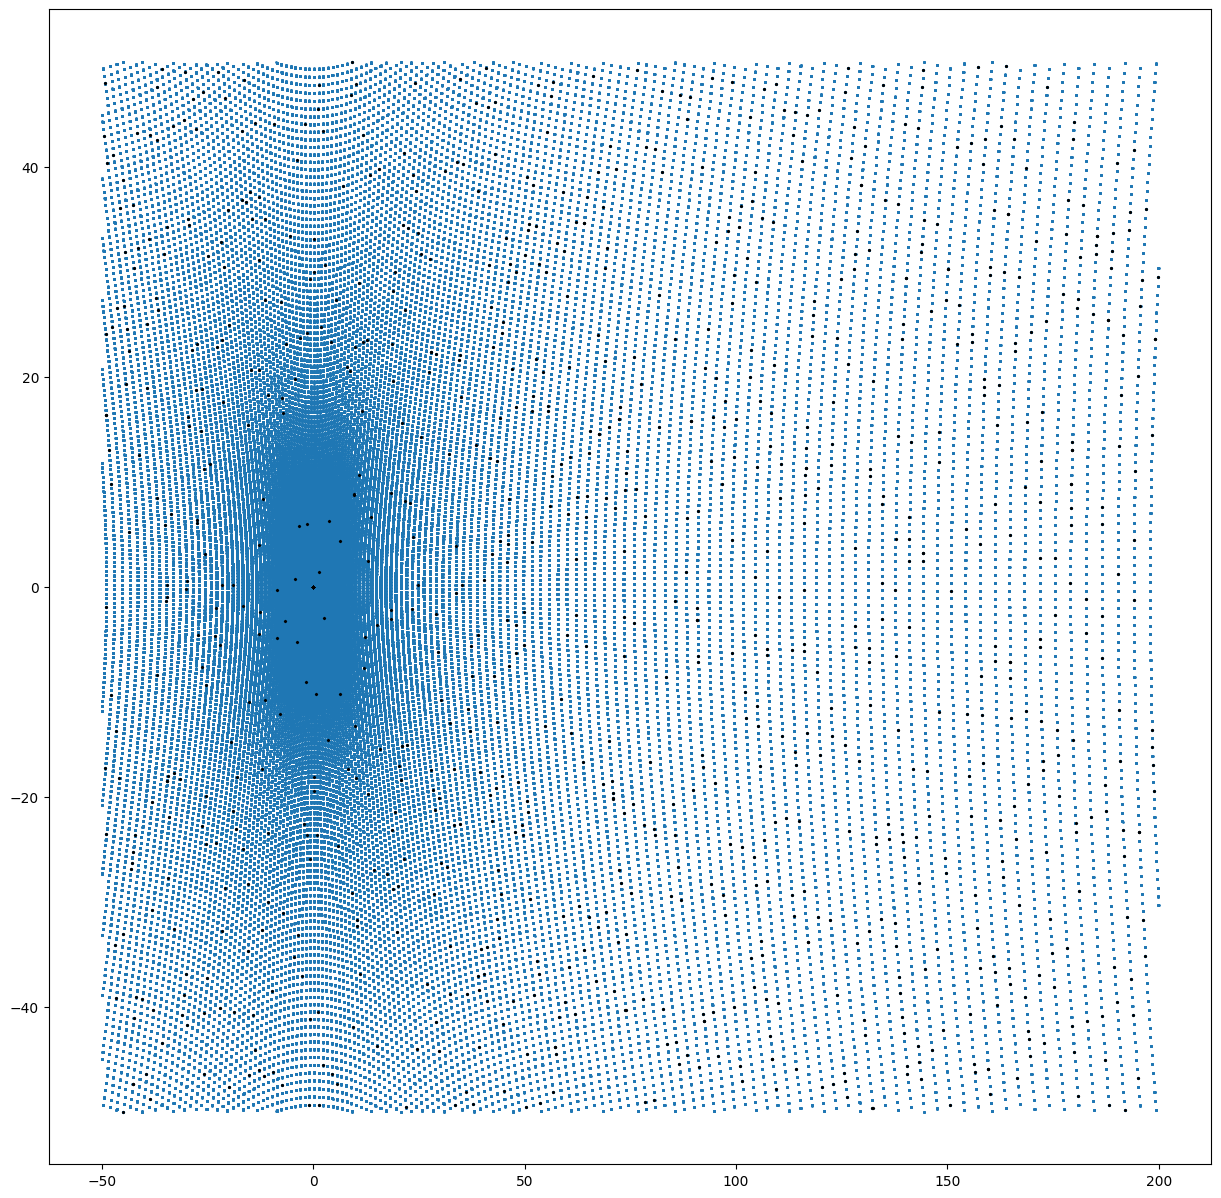

In [35]:
av = AdaptiveVoxelizer({
    "point_cloud_range": [-50, -50, -1, 200, 50, 3],
    "resolution": [1000, 1000, 50],
    "scaling": 0.3,
})
points = ((torch.rand(1000, 3)) * (av.grid_max - av.grid_min) + av.grid_min).T
voxels = av(points)

plt.figure(figsize=(15, 15))
plt.scatter(av.pts_adaptive_filtered[0], av.pts_adaptive_filtered[1], s=1)
plt.scatter(voxels[0], voxels[1], s=2, marker="x", c="k")

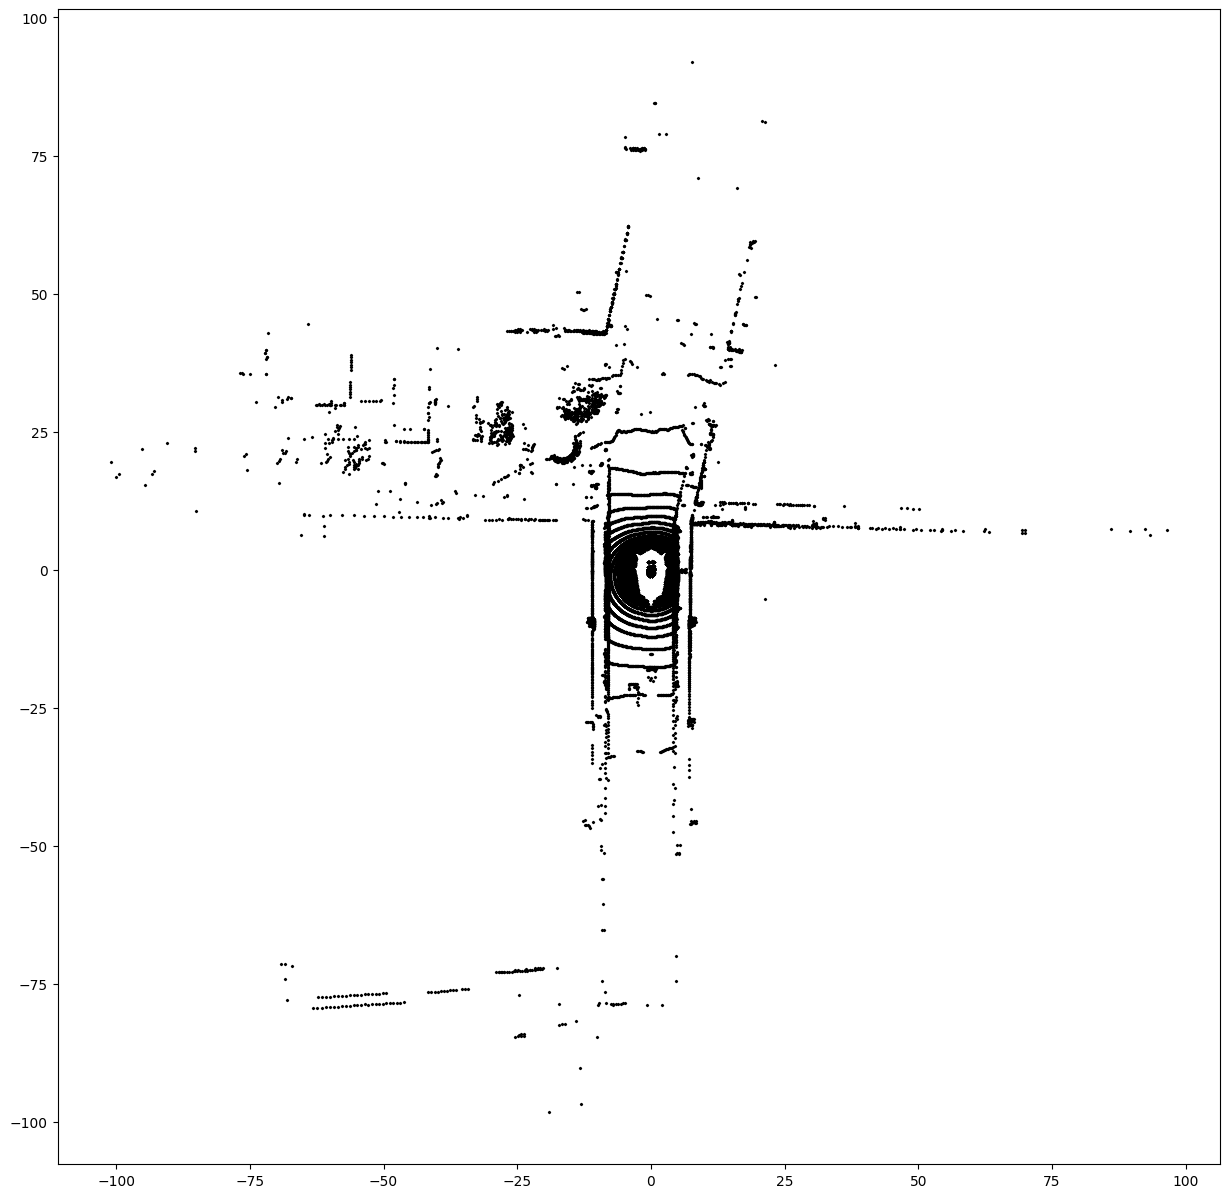

In [41]:
points = torch.from_numpy((np.fromfile("data/nuscenes_datasample.bin", dtype=np.float32).reshape(-1, 5).T)[:3])

plt.figure(figsize=(15, 15))
plt.scatter(points[0], points[1], s=2, marker="x", c="k")

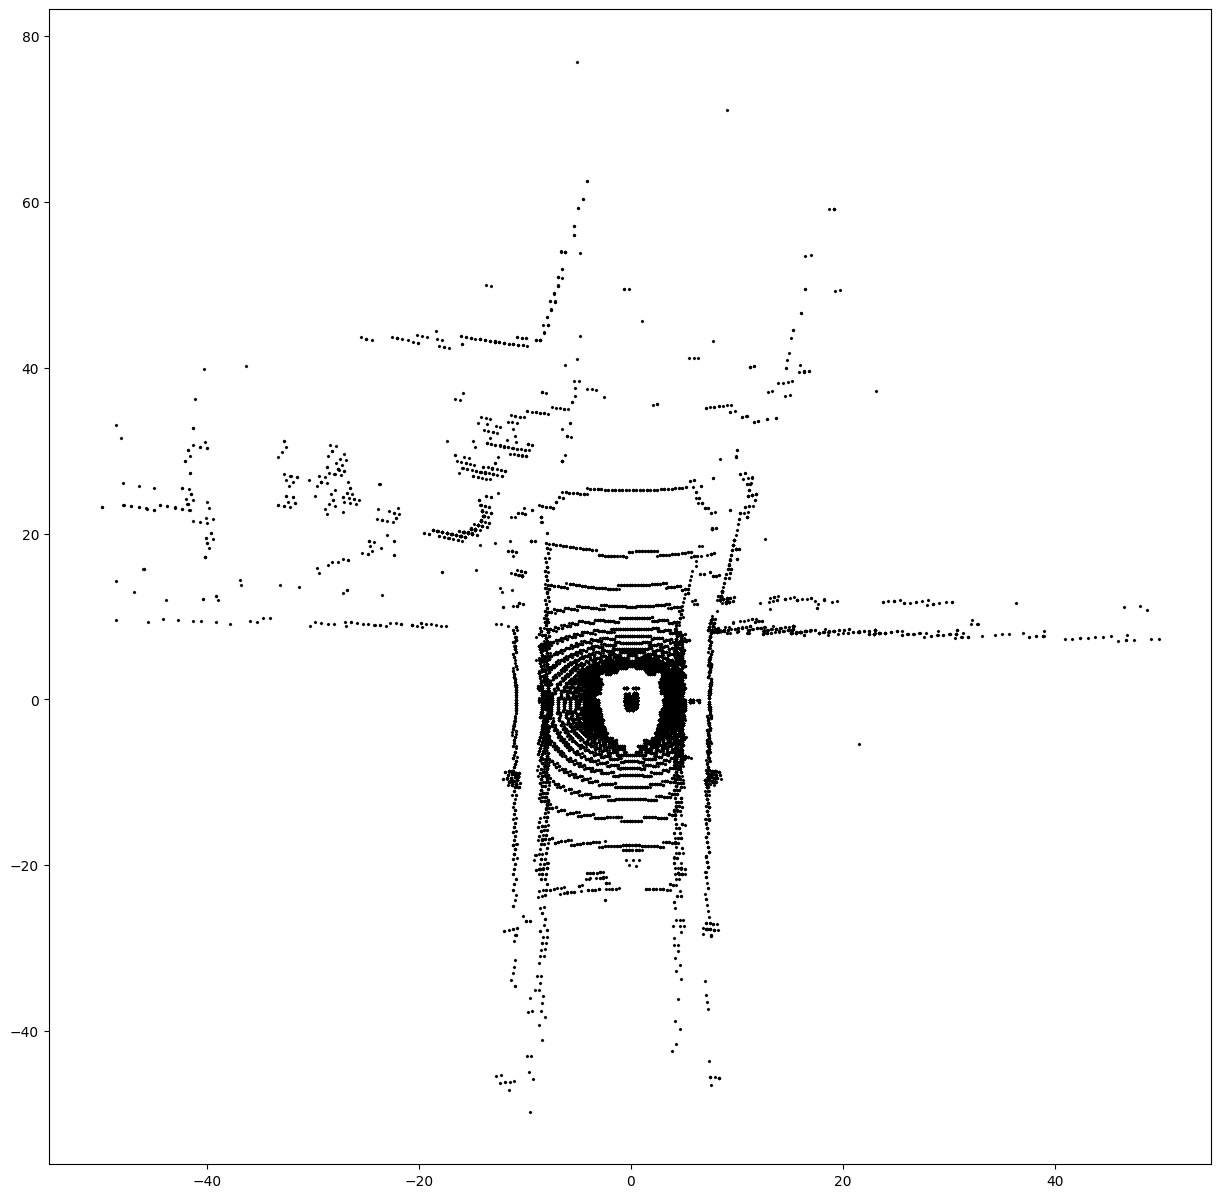

In [36]:
points = torch.from_numpy((np.fromfile("data/nuscenes_datasample.bin", dtype=np.float32).reshape(-1, 5).T)[:3])

av = AdaptiveVoxelizer({
    "point_cloud_range": [-50, -50, -3, 50, 80, 3],
    "resolution": [1000, 1000, 50],
    "scaling": 0.3,
})
voxels = av(points)

plt.figure(figsize=(15, 15))
plt.scatter(voxels[0], voxels[1], s=2, marker="x", c="k")

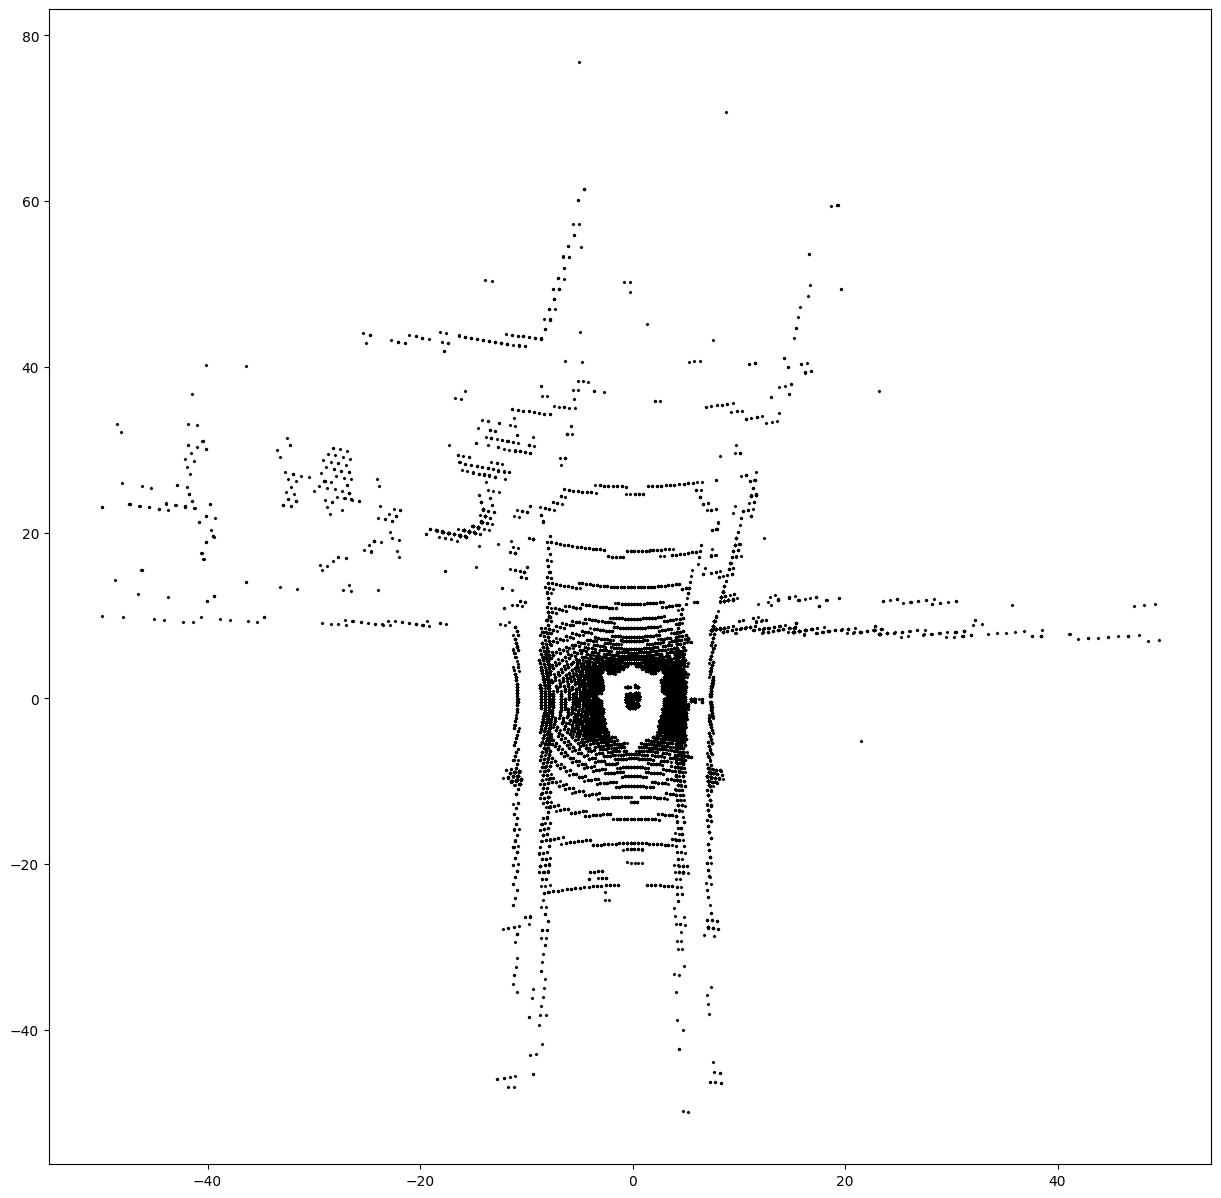

In [39]:
points = torch.from_numpy((np.fromfile("data/nuscenes_datasample.bin", dtype=np.float32).reshape(-1, 5).T)[:3])

av = AdaptiveVoxelizer({
    "point_cloud_range": [-50, -50, -3, 50, 80, 3],
    "resolution": [1000, 1000, 50],
    "scaling": 0.5,
})
voxels = av(points)

plt.figure(figsize=(15, 15))
plt.scatter(voxels[0], voxels[1], s=2, marker="x", c="k")

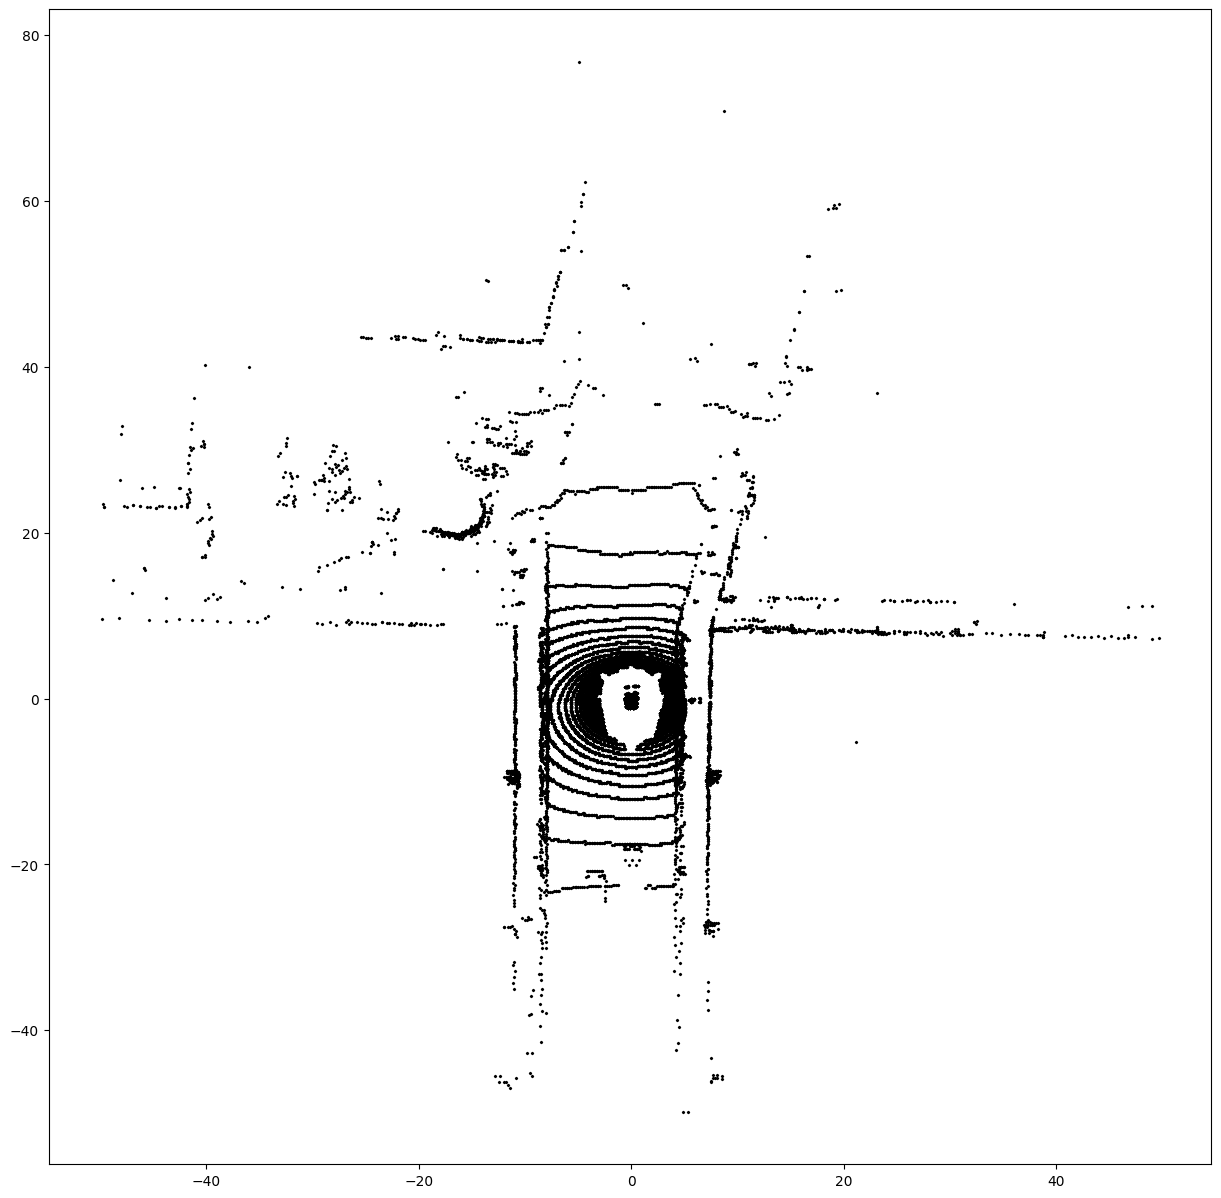

In [40]:
points = torch.from_numpy((np.fromfile("data/nuscenes_datasample.bin", dtype=np.float32).reshape(-1, 5).T)[:3])

av = AdaptiveVoxelizer({
    "point_cloud_range": [-50, -50, -3, 50, 80, 3],
    "resolution": [1000, 1000, 50],
    "scaling": 0.05,
})
voxels = av(points)

plt.figure(figsize=(15, 15))
plt.scatter(voxels[0], voxels[1], s=2, marker="x", c="k")